## AOS1, Rendering of TP n ° 4: CARVALHO Philippe and HUONG-PARRAIN Anathan
10/21/2019

# TP 4: Estimation of cumulated debit card usage in Iceland between January and April 2013

In order to estimate the cumulated debit card usage using the provided dataset, we need to analyze it : namely, identify which ARIMA model best fits it. We will then be able to use this model to run a prediction for the specified time frame.

## <font color=CornflowerBlue>Dependency imports</font>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')

## <font color=CornflowerBlue>Loading Data</font>

In [2]:
data = pd.read_csv('./data/debitcards.csv', parse_dates = True, index_col = 0)

## <font color=CornflowerBlue>Check integrity of loaded dataset</font>

In [3]:
assert(data.shape == (12*13,1)) # twelve values between January 2000 and december 2012
assert(type(data.index) is pd.core.indexes.datetimes.DatetimeIndex)

In [4]:
# In order to avoid some future warnings, the frequency of the time series is set to monthly
data.index.freq = "MS"

## <font color=CornflowerBlue>Data plot</font>

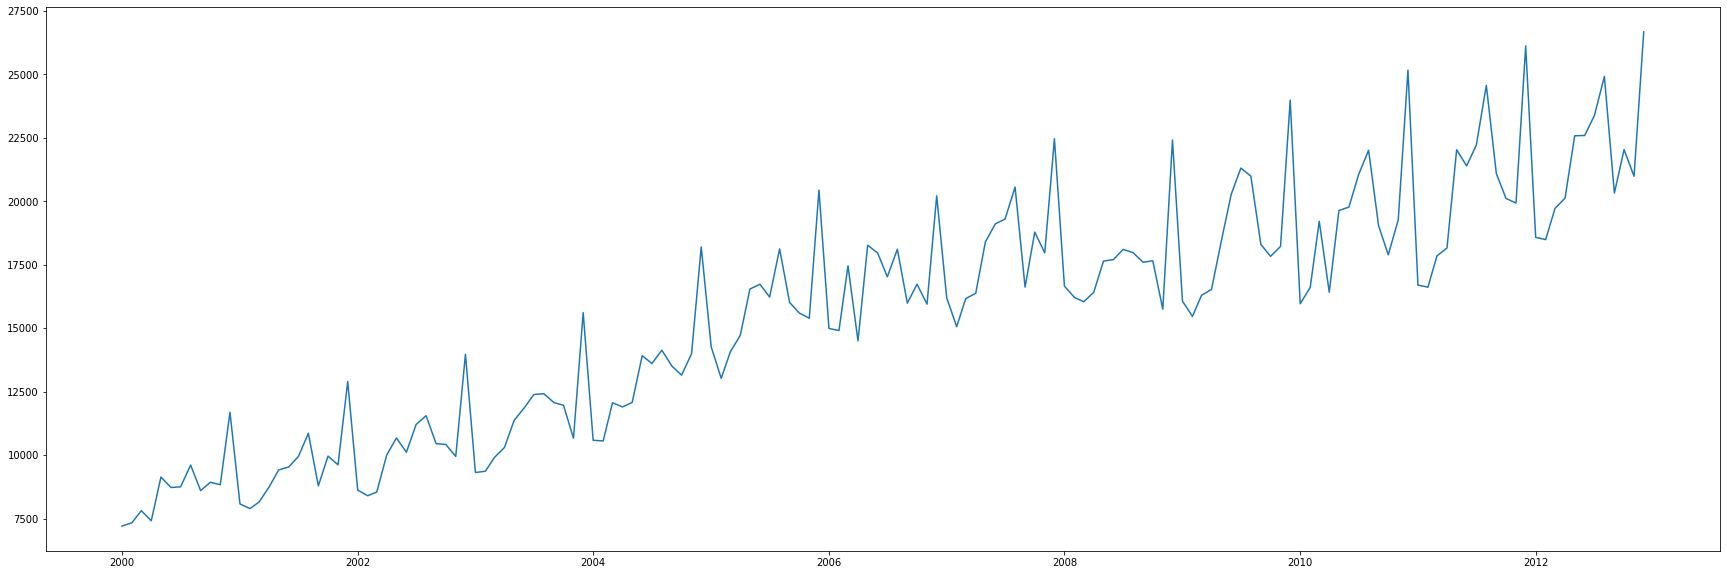

In [5]:
#We call the following function so we can avoid a warning
register_matplotlib_converters()
plt.figure(figsize=(30,10))
plt.plot(data)

We can see what the trend seems to be growing over the years. We can also see that there are spikes at regular intervals, which might indicate a seasonal component. In order to confirm this observation, we can look at each year's graphs to see if we can find these spikes.

## <font color=CornflowerBlue>Display of yearly trend</font>

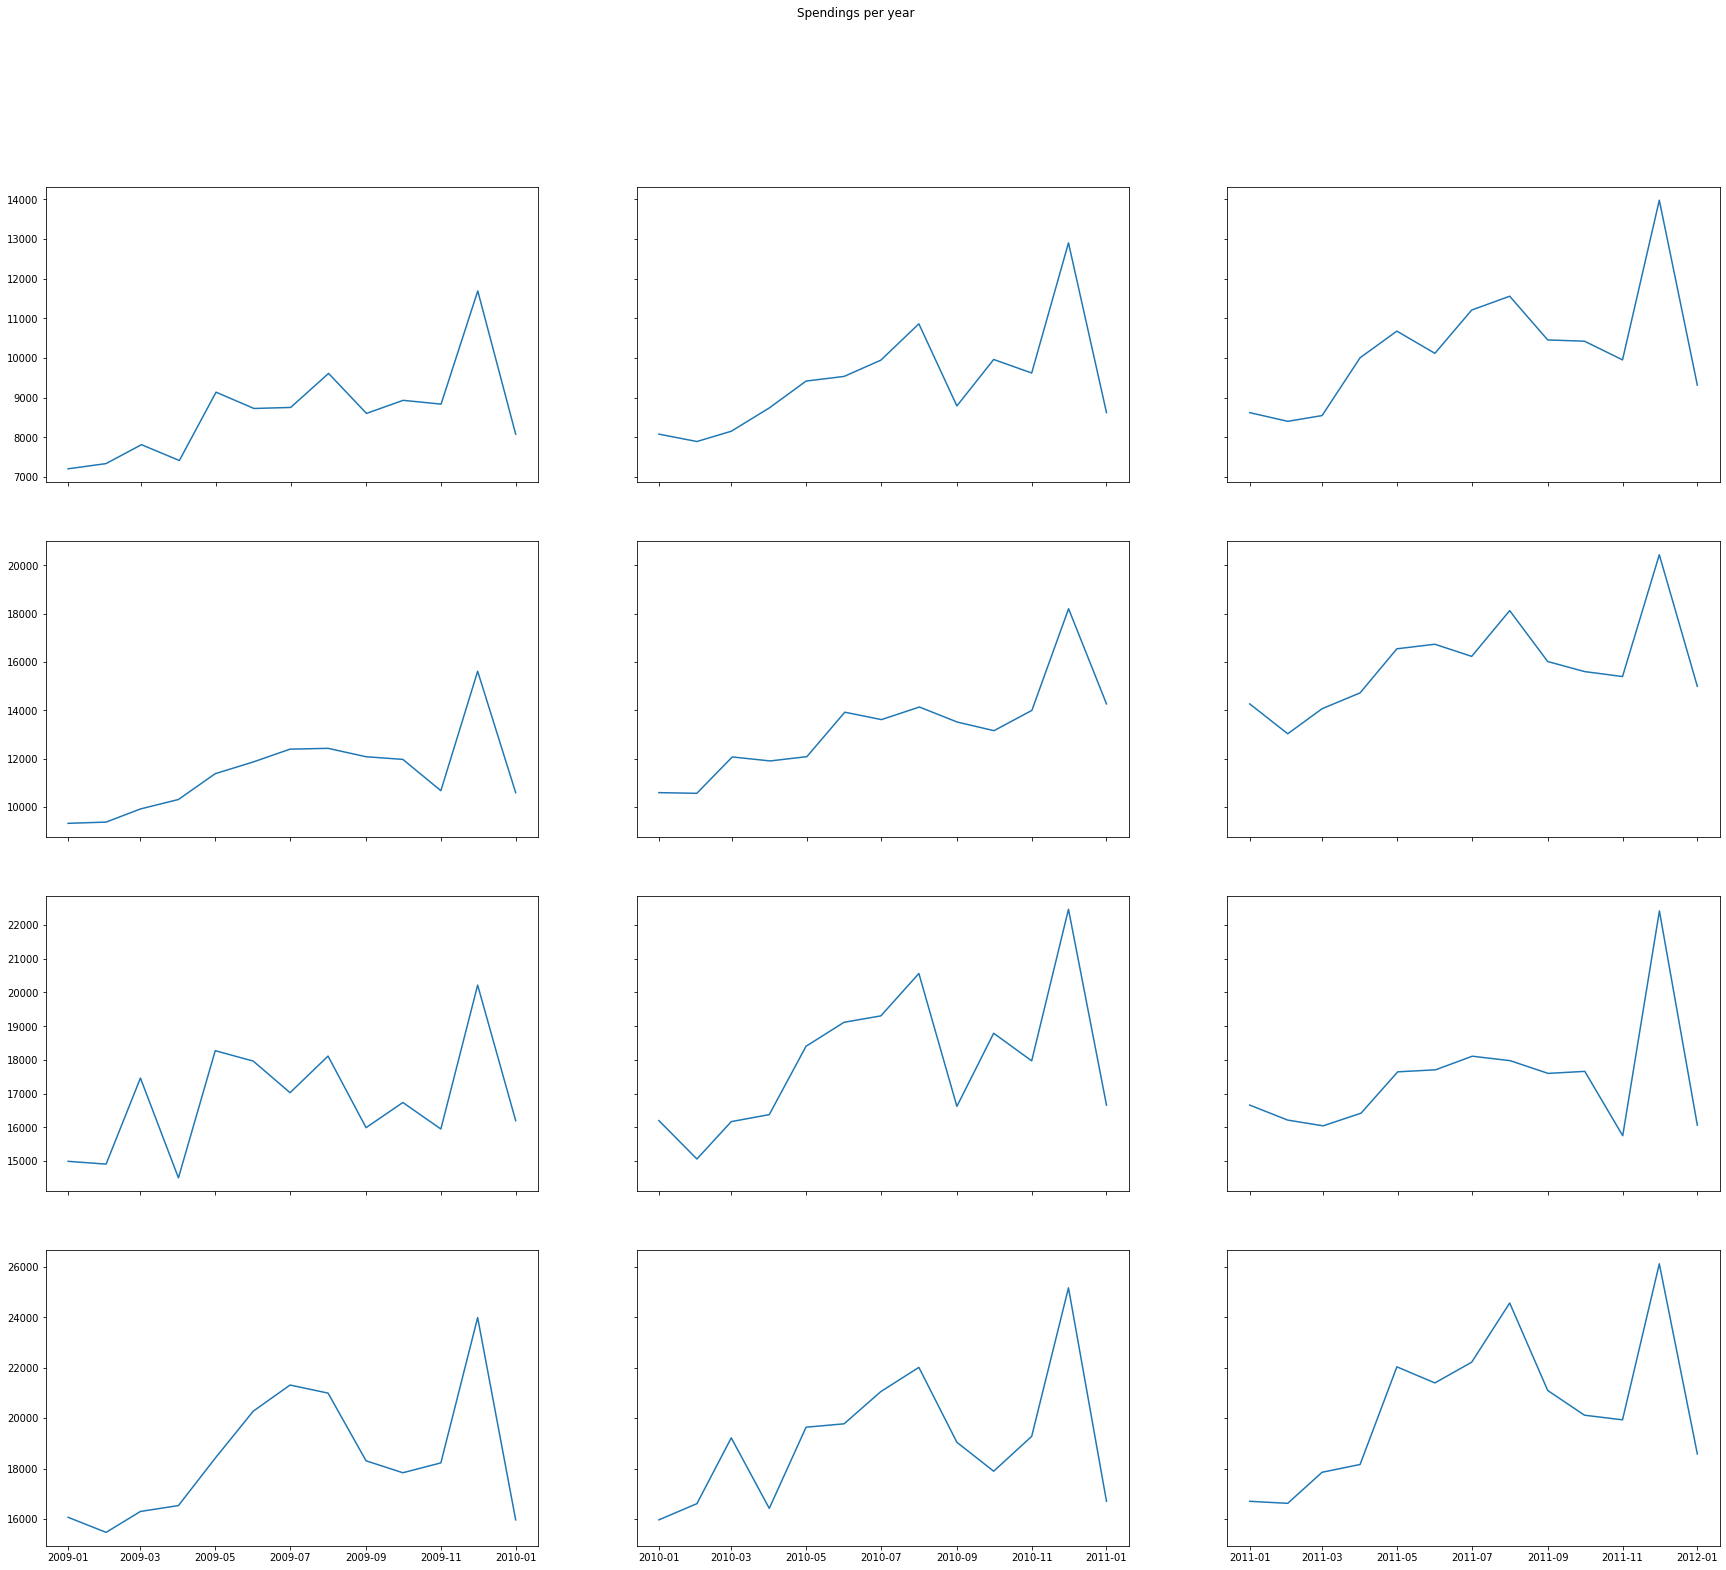

In [6]:
periods = []
for year in range(2000,2013):
    periods.append('1-1-' + str(year))

fig, axs = plt.subplots(4, 3, sharey='row', figsize=(30,25))
fig.suptitle('Spendings per year')

per = 0
for ax_dim in axs:
    for ax in ax_dim:
        ax.plot(data[periods[per]:periods[per+1]])
        per = per+1

for ax in axs.flat:
    ax.label_outer()

We can see :

**1)** That the overall trend is growing linearly over the years (growth of debit card usage)

**2)** That the trend is higher between the months of June and August (summer period)

**3)** That the trend rises significatively for the month of December (end of the year festivities) and drops significatively for the month of January

We will start by testing the first hypothesis formally using an augmented Dickey-Fuller test.

## <font color=CornflowerBlue >Stationarity test (Augmented Dickey-Fuller statistical test)</font>

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
adf_test = adfuller(data.to_numpy().reshape(-1))
print("Null hypothesis : autoregressive model has a unit root <=> the time series is not stationary")
print("P-value : ", str(adf_test[1]))

Null hypothesis : autoregressive model has a unit root <=> the time series is not stationary
P-value :  0.7881064417185544


The p-value is greater than 0.05, therefore we cannot reject the null hypothesis. Consequently, we cannot consider that the time series is stationary : the trend of the time series evolves over time and this confirms our first hypothesis.

Our hypothesis holds that the trend grows linearly : therefore, a simple differenciation of the series should make it stationary.

## <font color=CornflowerBlue>Differenciation of the series and test of stationarity</font>

We create a differenciated series.

We apply time shifting in order to subtract every the point by the one that preceded it.

In [9]:
#create a differenced series

data_shift = data - data.shift(1)
data_shift.dropna(inplace=True)

We test for the stationarity of the newly created time series.

In [10]:
adf_test2 = adfuller(data_shift.to_numpy().reshape(-1))
print("Null hypothesis : autoregressive model has a unit root <=> the time series is not stationary")
print("P-value : ", str(adf_test2[1]))

Null hypothesis : autoregressive model has a unit root <=> the time series is not stationary
P-value :  0.03815703587781203


Given a confidence level of 5%, we can reject the null hypothesis and we can consider that the time series is stationary.

We are going to determine which model best fits our series : moving average (MA), autoregressive model (AR) or a combination of them (ARMA, here ARIMA since we need to differentiate our model once to make it stationary)

## <font color=CornflowerBlue>Plot of ACF and PACF for the choice of the coefficients of MA and AR in an ARIMA model</font>

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In order to determine what orders we give to each component in the ARIMA model, we can look at the autocorrelation and partial autocorrelation plots. An analysis of the shape of these graphs will give us an estimation of the parameters of the model.

Namely, two overall decaying graphs will suggest an ARMA model. An ACF graph whose spikes are negligible past a certain spike n will give us a MA(n) model. A similar PACF graph will suggest an AR(n) model.

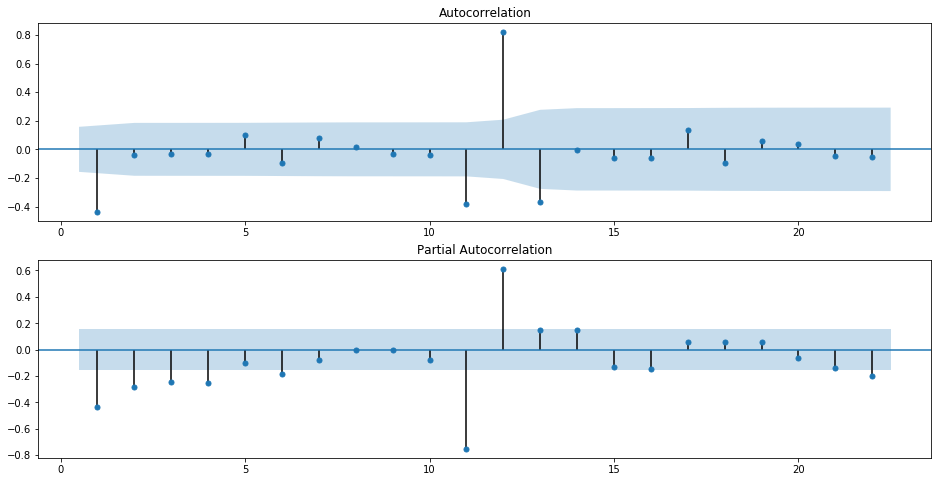

In [12]:
fig, ax = plt.subplots(2, figsize=(16, 8))
plot_acf(data_shift, zero=False, ax=ax[0])
plot_pacf(data_shift, zero=False, ax=ax[1])
plt.show()

ACF: All lags after the 13th lag are negligible

PACF: All lags after the 12th lag are negligible

Therefore, two models stand out : **MA(13)** and **AR(12)**.

We will first do an analysis with the first model.

### Data split between training set and test set :

In [13]:
splitDate = "2008-08-01"

data_train = data[:splitDate]
data_test = data[splitDate:]

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX as sarimax

## <font color=CornflowerBlue>Application of the ARIMA model with p=0, q=13 and d=1 (MA model)</font>

### Fit of the ARIMA model with the above parameters and our data:

In [15]:
model1 = sarimax(data_train, order=(0, 1, 13))
model1_fit = model1.fit()

C:\Users\Anathan\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Display of diagnostics plots :

In [16]:
model1_diagnostics = model1_fit.plot_diagnostics()
model1_diagnostics.show()

Looking at the histogram of residuals and the normal Q-Q-plot, we can notice that :

- Residuals seem to be normally distributed

- The correlogram shows that they are not correlated

### Predictions on the test set

In [17]:
model1_test = sarimax(data, order=(0, 1, 13))
model1_test_res = model1_test.filter(model1_fit.params)
pred1 = model1_test_res.get_prediction(start=splitDate)

#Extraction of the confidence interval for each prediction
pred1_ci = pred1.conf_int()

### Plot and MSE of the model:

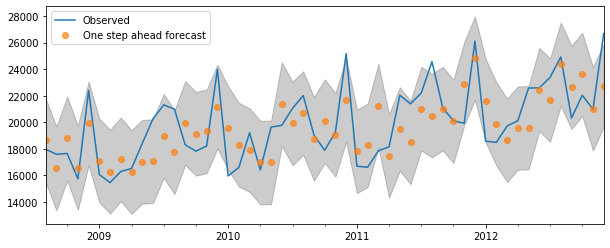

In [18]:
#Plot of the data test (observed) and the one step ahead forecast data
ax = data_test.plot(y="V1", label="Observed", figsize=(10, 4))
pred1.predicted_mean.plot(ax=ax, label="One step ahead forecast", alpha=0.7, linestyle='', marker='o')
ax.fill_between(pred1_ci.index, pred1_ci['lower V1'], pred1_ci['upper V1'], color="k", alpha=0.2)
plt.legend()

In [19]:
mse = np.mean((pred1.predicted_mean - data_test.V1)**2)
print("The mean squared error between real and one step ahead predicted values is: " + str(mse))

The mean squared error between real and one step ahead predicted values is: 3945110.3682980486


## <font color=CornflowerBlue>Application of the ARIMA model with p=12, q=0 and d=1 (AR model)</font>

We repeat the previous steps with the second model :

In [20]:
model2 = sarimax(data_train, order=(12, 1, 0))
model2_fit = model2.fit()

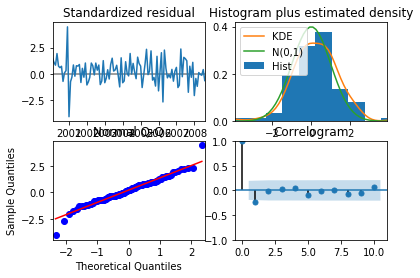

In [21]:
model2_diagnostics = model2_fit.plot_diagnostics()
model2_diagnostics.show()

The same observations as earlier hold for these diagnostics plots.

In [22]:
model2_test = sarimax(data, order=(12, 1, 0))
model2_test_res = model2_test.filter(model2_fit.params)
pred2 = model2_test_res.get_prediction(start=splitDate)
pred2_ci = pred2.conf_int()

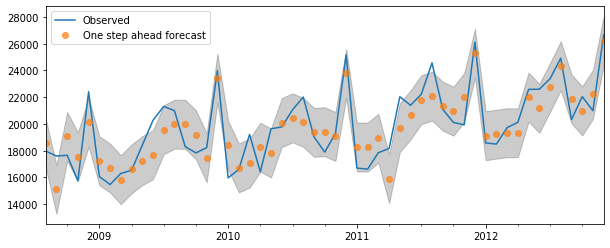

In [23]:
ax2 = data_test.plot(y="V1", label="Observed", figsize=(10, 4))
pred2.predicted_mean.plot(ax=ax2, label="One step ahead forecast", alpha=0.7, linestyle='', marker='o')
ax2.fill_between(pred2_ci.index, pred2_ci['lower V1'], pred2_ci['upper V1'], color="k", alpha=0.2)
plt.legend()

In [24]:
mse2 = np.mean((pred2.predicted_mean - data_test.V1)**2)
print("The MSE of the model is: " + str(mse2))

The MSE of the model is: 1936002.2717321957


The MSE of the second model is much lower than the MSE of the second model, which is an indication that the AR model is a better fit than the MA model.

We will now test the prediction of the estimated cumulated debit card usage for the months of January - April 2012 (using as much data as possible to see how reliable the model is for early-year predictions) with both models.

## <font color=CornflowerBlue> Estimation of the cumulated debit card usage during January - April 2012</font>

In [25]:
splitDate = "2012-01-01"

data_train = data[:splitDate]
data_test = data[splitDate:]

In [26]:
model1 = sarimax(data_train, order=(0, 1, 13))
model1_fit = model1.fit()

model2 = sarimax(data_train, order=(12, 1, 0))
model2_fit = model2.fit()

C:\Users\Anathan\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [27]:
#MA model
model1_test = sarimax(data, order=(0, 1, 13))
model1_test_res = model1_test.filter(model1_fit.params)
pred1 = model1_test_res.get_prediction(start=splitDate)
pred1_ci = pred1.conf_int()

#AR model
model2_test = sarimax(data, order=(12, 1, 0))
model2_test_res = model2_test.filter(model2_fit.params)
pred2 = model2_test_res.get_prediction(start=splitDate)
pred2_ci = pred2.conf_int()

### MA model

In [28]:
real_usage = sum(np.array(data_test[0:4]).T.flatten())
est_usage = sum(np.array(pred1.predicted_mean)[0:4])

print('real cumulated debit card usage: ', str(real_usage))
print('estimated cumulated debit card usage: ', str(est_usage))
print('MSE : ', str((real_usage - est_usage)**2))

real cumulated debit card usage:  76919.0
estimated cumulated debit card usage:  80530.0288365034
MSE :  13039529.258059146


### AR model

In [29]:
real_usage = sum(np.array(data_test[0:4]).T.flatten())
est_usage = sum(np.array(pred2.predicted_mean)[0:4])

print('Real cumulated debit card usage: ', str(real_usage))
print('Estimated cumulated debit card usage: ', str(est_usage))
print('MSE of mean estimation error: ', str((real_usage - est_usage)**2))

Real cumulated debit card usage:  76919.0
Estimated cumulated debit card usage:  76549.19648926903
MSE of mean estimation error:  136754.63654895042


We can see that the error is much lower for the AR model. This is the model that we are going to use for our prediction.

## <font color=CornflowerBlue> Estimation of the cumulated debit card usage during the months of January - April 2013</font>

In [30]:
model = sarimax(data, order=(12, 1, 0))
model_fit = model.fit()

In [31]:
pred = model_fit.get_prediction(start="2013-01-01",end='2013-04-01')
pred_ci = pred.conf_int()

In [32]:
print(pred.predicted_mean)

2013-01-01    19984.115027
2013-02-01    20196.608816
2013-03-01    21105.131112
2013-04-01    21123.308114
Freq: MS, dtype: float64


In [33]:
real_usage = sum(np.array(data_test[0:4]).T.flatten())
est_usage = sum(np.array(pred.predicted_mean)[0:4])

print('Estimated cumulated debit card usage: ', str(est_usage))

Estimated cumulated debit card usage:  82409.16306866179
